# Feature map extractor

In [1]:
# ！/home/dl5n19/.conda/envs/pytorch/bin/python

import os

import PIL
import numpy as np
import torch
import torch.nn.functional as F
import torchvision
from torch import nn
from torchvision import transforms

device = "cuda:0" if torch.cuda.is_available() else "cpu"
transform_image = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),  # convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.ToTensor(),  # convert to tensor
])

# feed-forward convolutional encoder network
vgg = torchvision.models.vgg16(pretrained=True)
resnet = torchvision.models.resnet152(pretrained=True)
vgg.eval()
resnet.eval()

def fm_resize(feature):
    return F.interpolate(feature.unsqueeze(0), size=[3, 28, 28], mode="trilinear", align_corners=False).view(3,28,28)

def get_feature_map_vgg16(image):
    list_vgg16 = [5, 10, 17, 24, 31]
    img = torch.tensor([]).to(device)
    for i in list_vgg16:
        feature_extractor_model = nn.Sequential(*list(vgg.children())[0][0:i])
        feature_extractor_model.eval()
        feature_extractor_model = feature_extractor_model.to(device)
        feature = feature_extractor_model(image.unsqueeze(0))
        img = torch.cat([img, fm_resize(feature)], 0)
    return img


def get_feature_map_Resnet152(image):
    list_resnet152 = [4, 5, 6, 7, 8]
    img = torch.tensor([]).to(device)
    for i in list_resnet152:
        feature_extractor_model = nn.Sequential(*list(resnet.children())[0:i])
        feature_extractor_model.eval()
        feature_extractor_model = feature_extractor_model.to(device)
        feature = feature_extractor_model(image.unsqueeze(0))
        img = torch.cat([img, fm_resize(feature)], 0)
    return img


path_images = '/home/dl5n19/dl/coursework/dataset/DUTS/DUTS-TE/DUTS-TE-Image' # Image dataset
list_dir = os.listdir(path_images)
training_features = torch.tensor([])
training_features_vgg = torch.tensor([])
training_features_resnet = torch.tensor([])
k = 0
for path in list_dir:
    print(k)
    k += 1

    # torch.cuda.empty_cache()
    image = transform_image(PIL.Image.open(os.path.join(path_images, path)))
    features = transform(PIL.Image.open(os.path.join(path_images, path)))
    features_vgg = get_feature_map_vgg16(image.to(device))
    features_resnet = get_feature_map_Resnet152(image.to(device))

    training_features = torch.cat((training_features, features.data.unsqueeze(0).cpu()), 0)
    training_features_vgg = torch.cat((training_features_vgg, features_vgg.data.unsqueeze(0).cpu()), 0)
    training_features_resnet = torch.cat((training_features_resnet, features_resnet.data.unsqueeze(0).cpu()), 0)

np.save('/home/dl5n19/mydocuments/macOS/dl/coursework/fm/training_features', training_features)
np.save('/home/dl5n19/mydocuments/macOS/dl/coursework/fm/training_features_vgg', training_features_vgg)
np.save('/home/dl5n19/mydocuments/macOS/dl/coursework/fm/training_features_resnet', training_features_resnet)



KeyboardInterrupt



# Model training

In [250]:
import os

import PIL
import torch
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchbearer import Trial
from torchvision import transforms


In [251]:
# GT transform
path_gt = 'gt/gt_gau.png'
transform_gt = transforms.Compose([
            transforms.Resize((26,26)),
            transforms.ToTensor(),  # convert to tensor
])

# load feature map data
training_features = np.load('fm/training_features.npy')
training_features_vgg = np.load('fm/training_features_vgg.npy')
training_features_resnet = np.load('fm/training_features_resnet.npy')

# Dataset setting
class Mydataset(Dataset):
    def __init__(self, transform_gt: object, opt: object) -> object:
        self.size = training_features.shape[0]
        self.transform_gt = transform_gt
        self.opt = opt
    
    def __getitem__(self, index):  
        if index >= len(self):
            raise IndexError("{} index out of range".format(self.__class__.__name__))
         
        if self.opt == '': # Image
            fm = torch.tensor(training_features[index]*255)
        elif self.opt == 'Vgg':
            fm = torch.tensor(training_features_vgg[index])
        elif self.opt == 'Resnet':
            fm = torch.tensor(training_features_resnet[index])
            
        gt = PIL.Image.open(path_gt) #GT
        if self.transform_gt:
            gt = self.transform_gt(gt)
            
        return fm, gt
    
    def __len__(self):
        return self.size

In [252]:
# Position encoding module
class PosENet(nn.Module):
    def __init__(self, input_dim):
        super(PosENet, self).__init__()
        self.conv = nn.Conv2d(input_dim, 1, (3, 3), stride=1, padding=0)
        torch.manual_seed(3)
        nn.init.xavier_uniform_(self.conv.weight, gain=1)
            
    def forward(self, x):
        out = self.conv(x)
        return out

In [253]:
# define the GPU device
device = "cuda:0" if torch.cuda.is_available() else "cpu"
learning_rate = 0.001

In [254]:
# PosEnet
# Dataloader setting
train_data = Mydataset(transform_gt=transform_gt, opt='') # opt = '', 'Vgg' or 'Resnet'
trainloader = DataLoader(train_data, batch_size=4, shuffle=True)

# Define the components
model = PosENet(input_dim=train_data[0][0].shape[0]).to(device)
optimiser = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimiser = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimiser, lr_lambda=lambda epoch: 1/(epoch+1))
loss_function = nn.MSELoss()

# Train the module
trial = Trial(model, optimiser, loss_function, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader)
trial.run(epochs=15)
torch.save(model.state_dict(), 'weights/model_3_0_gau.weights')

In [255]:
# Vgg
# Dataloader setting
train_data_vgg = Mydataset(transform_gt=transform_gt, opt='Vgg') # opt = '', 'Vgg' or 'Resnet'
trainloader_vgg = DataLoader(train_data_vgg, batch_size=4, shuffle=True)

# Define the components
model_vgg = PosENet(input_dim=train_data_vgg[0][0].shape[0]).to(device)
optimiser_vgg = optim.Adam(model_vgg.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimiser_vgg = optim.SGD(model_vgg.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimiser_vgg, lr_lambda=lambda epoch: 1/(epoch+1))
loss_function_vgg = nn.MSELoss()

# Train the module
trial = Trial(model_vgg, optimiser_vgg, loss_function_vgg, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader_vgg)
trial.run(epochs=15)
torch.save(model_vgg.state_dict(), 'weights/model_vgg_3_0_gau.weights')

In [256]:
# Resnet
# Dataloader setting
train_data_resnet = Mydataset(transform_gt=transform_gt, opt='Resnet') # opt = '', 'Vgg' or 'Resnet'
trainloader_resnet = DataLoader(train_data_resnet, batch_size=4, shuffle=True)

# Define the components
model_resnet = PosENet(input_dim=train_data_resnet[0][0].shape[0]).to(device)
optimiser_resnet = optim.Adam(model_resnet.parameters(), lr=learning_rate, weight_decay=1e-4)
# optimiser_resnet = optim.SGD(model_resnet.parameters(), lr=learning_rate, momentum=0.9, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.LambdaLR(optimiser_resnet, lr_lambda=lambda epoch: 1/(epoch+1))
loss_function_resnet = nn.MSELoss()

# Train the module
trial = Trial(model_resnet, optimiser_resnet, loss_function_resnet, metrics=['loss', 'accuracy']).to(device)
trial.with_generators(trainloader_resnet)
trial.run(epochs=15)
torch.save(model_resnet.state_dict(), 'weights/model_resnet_3_0_gau.weights')

# Evaluation

In [240]:
# Image transform
gt_size = 26
path_image = 'images/image.png'
path_gt = 'gt/gt_gau.png'

transform_image = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),  # convert to tensor
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225]),
        ])

transform = transforms.Compose([
            transforms.Resize((28,28)),
            transforms.ToTensor(),  # convert to tensor
        ])

transform_display = transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),  # convert to tensor
        ])

transform_gt = transforms.Compose([
            transforms.Resize((gt_size,gt_size)),
            transforms.ToTensor(),  # convert to tensor
        ])

In [241]:
# feed-forward convolutional encoder network
vgg = torchvision.models.vgg16(pretrained=True)
resnet = torchvision.models.resnet152(pretrained=True)

In [242]:
# Extractor

def fm_resize(feature):
    return F.interpolate(feature.unsqueeze(0), size=[3, 28, 28], mode="trilinear", align_corners=False).view(3,28,28)

def extractor_vgg(image):
    list_vgg16 = [5, 10, 17, 24, 31]
    img = torch.tensor([])
    for i in list_vgg16:
        feature_extractor_model = nn.Sequential(*list(vgg.children())[0][0:i])
        feature_extractor_model.eval()
        feature_extractor_model = feature_extractor_model
        feature = feature_extractor_model(image.unsqueeze(0))
        img = torch.cat([img, fm_resize(feature)], 0)
    return img

def extractor_resnet(image):
    list_resnet152 = [4, 5, 6, 7, 8]
    img = torch.tensor([])
    for i in list_resnet152:
        feature_extractor_model = nn.Sequential(*list(resnet.children())[0:i])
        feature_extractor_model.eval()
        feature_extractor_model = feature_extractor_model
        feature = feature_extractor_model(image.unsqueeze(0))
        img = torch.cat([img, fm_resize(feature)], 0)
    return img

# Position encoding module
class PosENet_eval(nn.Module):
    def __init__(self, input_dim):
        super(PosENet_eval, self).__init__()
        self.conv = nn.Conv2d(input_dim, 1, (3, 3), stride=1, padding=0)
            
    def forward(self, x):
        out = self.conv(x)
        return out

In [243]:
model = PosENet_eval(input_dim=3)
model_vgg = PosENet_eval(input_dim=15) # if input feature maps from 1 layer, input_dim need to modify to 3.
model_resnet = PosENet_eval(input_dim=15) # if input feature maps from 1 layer, input_dim need to modify to 3.

model.load_state_dict(torch.load('weights/model_3_0_gau.weights', map_location=torch.device('cpu')))
model_vgg.load_state_dict(torch.load('weights/model_vgg_3_0_gau.weights', map_location=torch.device('cpu')))
model_resnet.load_state_dict(torch.load('weights/model_resnet_3_0_gau.weights', map_location=torch.device('cpu')))

model.eval()
model_vgg.eval()
model_resnet.eval()

PosENet_eval(
  (conv): Conv2d(15, 1, kernel_size=(3, 3), stride=(1, 1))
)

In [244]:
img_model_PosENet = transform(PIL.Image.open(path_image))*255
img_model_vgg_resnet = transform_image(PIL.Image.open(path_image))

# Prediction
pred = model(img_model_PosENet.permute(0,2,1).unsqueeze(0))
pred_vgg = model_vgg(extractor_vgg(img_model_vgg_resnet.permute(0,2,1)).unsqueeze(0))
pred_resnet = model_resnet(extractor_resnet(img_model_vgg_resnet.permute(0,2,1)).unsqueeze(0))

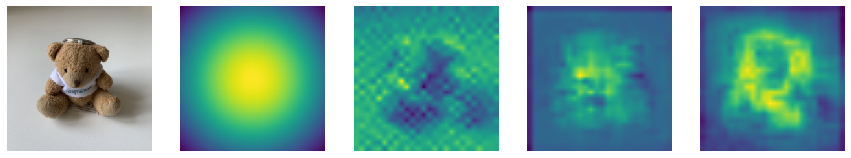

In [245]:
# set a display transform
img = transform_display(PIL.Image.open(path_image))
gt_img = transform_display(PIL.Image.open(path_gt))

pred_img = F.interpolate(pred, size=(224,224), mode="bilinear", align_corners=False)
pred_vgg_img = F.interpolate(pred_vgg, size=(224,224), mode="bilinear", align_corners=False)
pred_resnet_img = F.interpolate(pred_resnet, size=(224,224), mode="bilinear", align_corners=False)

# show the image and GT
plt.figure(figsize=(15,3))
plt.subplot(151);plt.imshow(img.permute(2, 1, 0), aspect='equal')
plt.axis('off')
plt.subplot(152);plt.imshow(gt_img[0], aspect='equal')
plt.axis('off')
plt.subplot(153);plt.imshow(pred_img[0,0,:,:].data, aspect='equal')
plt.axis('off')
plt.subplot(154);plt.imshow(pred_vgg_img[0,0,:,:].data, aspect='equal')
plt.axis('off')
plt.subplot(155);plt.imshow(pred_resnet_img[0,0,:,:].data, aspect='equal')
plt.axis('off')
plt.show()

In [246]:
# Spearman's rank correlation coefficient (SPC)
gt = transform_gt(PIL.Image.open(path_gt)).view(gt_size,gt_size).numpy()
data = pd.DataFrame({'PosENet':pred.view(gt.shape).detach().numpy().flatten(), 
                     'Vgg':pred_vgg.view(gt.shape).detach().numpy().flatten(), 
                     'Resnet':pred_resnet.view(gt.shape).detach().numpy().flatten(), 
                     'GT':gt.flatten() 
                    })

round(data.corr('spearman'), 3)['GT'][0:3]

PosENet   -0.242
Vgg        0.775
Resnet     0.886
Name: GT, dtype: float64

In [247]:
# mean absolute error (MAE)
print('PosENet: ', round(sum(abs((pred.view(gt.shape).detach().numpy()-gt).flatten())) / (gt_size ** 2), 3))
print('Vgg      ', round(sum(abs((pred_vgg.view(gt.shape).detach().numpy()-gt).flatten())) / (gt_size ** 2), 3))
print('Resnet   ', round(sum(abs((pred_resnet.view(gt.shape).detach().numpy()-gt).flatten())) / (gt_size ** 2), 3))

PosENet:  0.234
Vgg       0.141
Resnet    0.135


In [249]:
gt = transform_gt(PIL.Image.open(path_gt))
print(nn.functional.kl_div(pred, gt, reduction='mean'))
print(nn.functional.kl_div(pred_vgg, gt, reduction='mean'))
print(nn.functional.kl_div(pred_resnet, gt, reduction='mean'))

tensor(-0.6769, grad_fn=<KlDivBackward>)
tensor(-0.6067, grad_fn=<KlDivBackward>)
tensor(-0.5919, grad_fn=<KlDivBackward>)


# Image generation

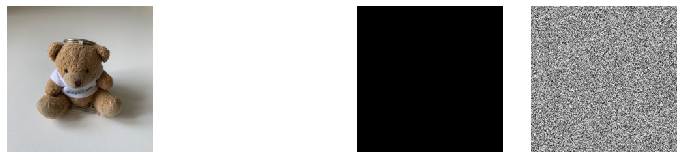

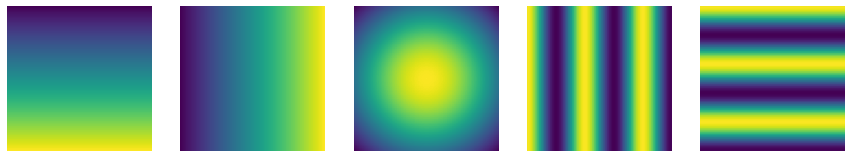

In [150]:
# Generate figures
image = transform_display(PIL.Image.open('images/image.png'))
white = transform_display(PIL.Image.open('images/white.png'))
black = transform_display(PIL.Image.open('images/black.png'))
noise = transform_display(PIL.Image.open('images/noise.png'))

plt.figure(figsize=(12,3))
plt.subplot(141);plt.imshow(image.permute(2, 1, 0), aspect='equal')
plt.axis('off')
plt.subplot(142);plt.imshow(white.permute(2, 1, 0), aspect='equal')
plt.axis('off')
plt.subplot(143);plt.imshow(black.permute(2, 1, 0), aspect='equal')
plt.axis('off')
plt.subplot(144);plt.imshow(noise.permute(2, 1, 0), aspect='equal')
plt.axis('off')
plt.show()

# show the image and GT
plt.figure(figsize=(15,3))
plt.subplot(151);plt.imshow(transform_display(PIL.Image.open('gt/gt_ver.png'))[0], aspect='equal')
plt.axis('off')
plt.subplot(152);plt.imshow(transform_display(PIL.Image.open('gt/gt_hor.png'))[0], aspect='equal')
plt.axis('off')
plt.subplot(153);plt.imshow(transform_display(PIL.Image.open('gt/gt_gau.png'))[0], aspect='equal')
plt.axis('off')
plt.subplot(154);plt.imshow(transform_display(PIL.Image.open('gt/gt_stpver.png'))[0], aspect='equal')
plt.axis('off')
plt.subplot(155);plt.imshow(transform_display(PIL.Image.open('gt/gt_stphor.png'))[0], aspect='equal')
plt.axis('off')
plt.show()